In [1]:
import os
import typing
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torch.utils.data
import torchvision
import tqdm
import matplotlib.pyplot as plt
import torch.distributions as dist
import abc

from torch.utils.data import DataLoader
from torch.distributions.distribution import Distribution

In [2]:
# Load MNIST dataset
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


train_loader = DataLoader(trainset, batch_size=32, shuffle=True)
test_loader = DataLoader(testset, batch_size=32, shuffle=False)


5


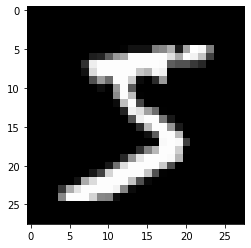

In [3]:
feature = trainset[0][0]
label = trainset[0][1]
print(label)
plt.imshow(feature.squeeze(), cmap='gray')
plt.show()


First, we need to define the Prior distributions which we will later use in the BNN.

In [4]:
class Prior(nn.Module, abc.ABC):
    """
    This class is a base class for all priors.
    It implements the log_likelihood and sample methods.
    The forward method is not used, but is required by nn.Module.
    This part of the code is inspired by the code from Vincent Fortuin:
    https://github.com/ratschlab/bnn_priors/blob/main/bnn_priors/prior/base.py
    """
    def __init__(self):
        super().__init__()

    @abc.abstractmethod
    def log_likelihood(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute the log-likelihood for the given x values
        """
        pass
    
    @abc.abstractmethod
    def sample(self) -> torch.Tensor:
        """
        Sample from the prior
        """
        pass

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Don't use this method, we only implement it because nn.Module requires it
        Vincent Fortuin uses the forward to return the parameter value using self.p
        """
        return self.log_likelihood(x)


In [5]:
class Isotropic_Gaussian(Prior):
    """
    Isotropic Gaussian prior

    """

    def __init__(self, mu: torch.Tensor, sigma: torch.Tensor):
        super(Isotropic_Gaussian, self).__init__()
        assert mu.size() == sigma.size()
        assert sigma > 0
        self.mu = mu
        self.sigma = sigma

    def log_likelihood(self, x: torch.Tensor) -> torch.Tensor:
        """
        Compute the log-likelihood for the given x values
        """
        return dist.Normal(self.mu, self.sigma).log_prob(x).sum()

    def sample(self) -> torch.Tensor:
        """
        Sample from the prior
        """
        return dist.Normal(self.mu, self.sigma).sample()





Next, we need to define a basic module for one single Bayesian Linear Layer. This module will then be used as building block for the full BNN. 


In [6]:
class Linear_Layer(nn.Linear):
    """
    Bayesian Linear Layer that will be used as a building block for the Bayesian Neural Network
    https://github.com/ratschlab/bnn_priors/blob/main/bnn_priors/models/layers.py
    """ 
    def __init__(self, in_features, out_features, weight_prior: Prior, bias_prior = None):
        nn.Module.__init__(self)
        (self.in_features, self.out_features) = (in_features, out_features)
        self.weight_prior = weight_prior
        self.bias_prior = bias_prior

    @property
    def weight(self):
        return self.weight_prior.sample()

    @property
    def bias(self):
        if self.bias_prior is None:
            return None
        else:
            return self.bias_prior.sample()



In [9]:
from torch.optim.optimizer import Optimizer, required

class SGLD(torch.optim.Optimizer):
    """
    SGLD optimiser based on pytorch's SGD.
    Note that the weight decay is specified in terms of the gaussian prior sigma.
    """

    def __init__(self, params, lr=required, norm_sigma=0, addnoise=True):

        weight_decay = 1 / (norm_sigma ** 2)

        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))

        defaults = dict(lr=lr, weight_decay=weight_decay, addnoise=addnoise)

        super(SGLD, self).__init__(params, defaults)

    def step(self):
        """
        Performs a single optimization step.
        """
        loss = None

        for group in self.param_groups:

            weight_decay = group['weight_decay']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)

                if group['addnoise']:

                    langevin_noise = p.data.new(p.data.size()).normal_(mean=0, std=1) / np.sqrt(group['lr'])
                    p.data.add_(-group['lr'],
                                0.5 * d_p + langevin_noise)
                else:
                    p.data.add_(-group['lr'], 0.5 * d_p)

        return loss

    

In [ ]:
class Bayesian_Neural_Network(nn.Module):
    """
    Bayesian Neural Network with a single hidden layer
    """
    def __init__(self, input_size, hidden_size, output_size, weight_prior, bias_prior):
        super(Bayesian_Neural_Network, self).__init__()

        self.input_layer = Linear_Layer(input_size, hidden_size, weight_prior, bias_prior)
        self.hidden_layer = Linear_Layer(hidden_size, output_size, weight_prior, bias_prior)
        self.act = nn.ReLU()

    def forward(self, x):
        x = self.act(self.input_layer(x))
        x = self.hidden_layer(x)
        return x

    

  
    

In [ ]:
# create the Bayesian Neural Network
model = Bayesian_Neural_Network(input_size=28*28, hidden_size=100, output_size=10)

# create the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# create the loss function
loss_fn = nn.CrossEntropyLoss()

# train the model
epochs = 15
progress_bar = tqdm.trange(epochs)

for epoch in progress_bar:
    for x, y in train_loader:
        # reshape the input
        x = x.view(-1, 28*28)

        # compute the output of the network
        y_hat, log_prior, log_posterior = model(x)

        # compute the loss
        loss = loss_fn(y_hat, y) - log_prior + log_posterior

        # compute the gradients
        loss.backward()

        # update the parameters
        optimizer.step()

        # reset the gradients
        optimizer.zero_grad()

    # compute the accuracy
    accuracy = (model.predict_class(x) == y).float().mean()

    # update the progress bar
    progress_bar.set_description(f"Epoch: {epoch+1}, Loss: {loss.item():.2f}, Accuracy: {accuracy:.2f}")